In [1]:
import sys
sys.path.append("/home/gonzalo/sw/git/Jupytools/")

from collections import defaultdict
from path import Path
from time import time

import numpy  as np
import polars as pl
import matplotlib.pyplot as plt

from nbtools import auto_plot_style
from pltools import normhist

In [2]:
%matplotlib inline
auto_plot_style()

In [3]:
folder = Path("/home/gonzalo/data/NEXT/resin/rmax_inf/")
folder = Path("/home/gonzalo/sw/git/resin/rust/data/rmax_inf/")
folder = Path("/home/gonzalo/sw/git/resin/rust/data/drmax_150/")
folder = Path("/home/gonzalo/sw/git/resin/rust/data/test/")
filenames = folder.glob("*.parquet")
len(filenames)

100

# Data quality check

In [4]:
filename = filenames[1]
df       = pl.read_parquet(filename)
pos      = df.select(list("xy"))
response = df.select(pl.col("^sipm.*$"))
df.head()

x,y,xabs,yabs,sipm_0,sipm_1,sipm_2,sipm_3,sipm_4,sipm_5,sipm_6,sipm_7,sipm_8,sipm_9,sipm_10,sipm_11,sipm_12,sipm_13,sipm_14,sipm_15,sipm_16,sipm_17,sipm_18,sipm_19,sipm_20,sipm_21,sipm_22,sipm_23,sipm_24,sipm_25,sipm_26,sipm_27,sipm_28,sipm_29,sipm_30,sipm_31,sipm_32,…,sipm_219,sipm_220,sipm_221,sipm_222,sipm_223,sipm_224,sipm_225,sipm_226,sipm_227,sipm_228,sipm_229,sipm_230,sipm_231,sipm_232,sipm_233,sipm_234,sipm_235,sipm_236,sipm_237,sipm_238,sipm_239,sipm_240,sipm_241,sipm_242,sipm_243,sipm_244,sipm_245,sipm_246,sipm_247,sipm_248,sipm_249,sipm_250,sipm_251,sipm_252,sipm_253,sipm_254,sipm_255
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-2.265331,1.894079,-122.265331,-118.105921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000282,0.000224,0.000177,0.000139,0.0,…,0.000428,0.000337,0.000261,0.000201,0.000155,0.0,0.000146,0.000182,0.000225,0.000275,0.000326,0.000372,0.000401,0.000406,0.000385,0.000345,0.000295,0.000244,0.000198,0.000159,0.000127,0.0,0.000117,0.000141,0.000169,0.000198,0.000227,0.000251,0.000266,0.000269,0.000258,0.000237,0.000209,0.00018,0.000151,0.000125,0.000104
3.441567,-2.92479,-16.558433,-32.92479,0.000103,0.000124,0.000149,0.000176,0.000204,0.00023,0.000249,0.000257,0.000254,0.000239,0.000215,0.000188,0.00016,0.000134,0.000111,0.000092,0.000127,0.000158,0.000196,0.00024,0.000288,0.000334,0.00037,0.000386,0.000379,0.00035,0.000307,0.000259,0.000213,0.000173,0.000139,0.000112,0.000156,…,0.000472,0.000356,0.000266,0.000201,0.000153,0.000146,0.000186,0.000237,0.0003,0.000371,0.000443,0.000502,0.00053,0.000518,0.00047,0.000401,0.000328,0.000262,0.000206,0.000162,0.000127,0.000119,0.000146,0.000179,0.000217,0.000258,0.000296,0.000325,0.000338,0.000333,0.000309,0.000274,0.000234,0.000195,0.000159,0.00013,0.000105
-0.399724,4.478842,59.600276,124.478842,0.000096,0.000118,0.000143,0.000173,0.000207,0.000241,0.000271,0.000292,0.000299,0.00029,0.000268,0.000237,0.000203,0.00017,0.00014,0.000115,0.000116,0.000146,0.000184,0.000231,0.000286,0.000347,0.000404,0.000445,0.000459,0.000442,0.000398,0.00034,0.00028,0.000225,0.000179,0.000142,0.000139,…,0.000489,0.0,0.0,0.0,0.0,0.000114,0.000143,0.00018,0.000225,0.000279,0.000336,0.00039,0.000429,0.000443,0.000426,0.000385,0.00033,0.0,0.0,0.0,0.0,0.000095,0.000116,0.000141,0.00017,0.000202,0.000234,0.000263,0.000283,0.00029,0.000281,0.00026,0.0,0.0,0.0,0.0,0.0
3.62079,4.163376,-66.37921,64.163376,0.00009,0.000108,0.000131,0.000156,0.000184,0.000211,0.000235,0.000251,0.000256,0.000249,0.000231,0.000206,0.000179,0.000152,0.000127,0.000105,0.000108,0.000135,0.000167,0.000207,0.000252,0.0003,0.000343,0.000374,0.000384,0.00037,0.000336,0.000292,0.000244,0.0002,0.000161,0.00013,0.00013,…,0.000575,0.000438,0.000329,0.000246,0.000186,0.000124,0.000157,0.000201,0.000255,0.000322,0.000395,0.000466,0.000518,0.000535,0.000511,0.000455,0.000383,0.00031,0.000245,0.000193,0.000151,0.000103,0.000127,0.000156,0.000191,0.00023,0.000271,0.000308,0.000333,0.000341,0.00033,0.000302,0.000264,0.000224,0.000185,0.000151,0.000122
4.66862,2.375922,-15.33138,-157.624078,0.0,0.0,0.0,0.0,0.0,0.0,0.000229,0.000243,0.000245,0.000237,0.000219,0.000195,0.000169,0.000143,0.00012,0.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.000335,0.000361,0.000366,0.00035,0.000316,0.000273,0.000228,0.000187,0.000151,0.000122,0.0,…,0.000573,0.000432,0.000321,0.00024,0.00018,0.0,0.0,0.0,0.0,0.0,0.000426,0.0005,0.000551,0.000562,0.000529,0.000463,0.000384,0.000308,0.000242,0.000189,0.000148,0.0,0.0,0.0,0.0,0.0,0.000289,0.000326,0.000351,0.000356,0.00034,0.000308,0.000267,0.000223,0.000184,0.000149,0.000121


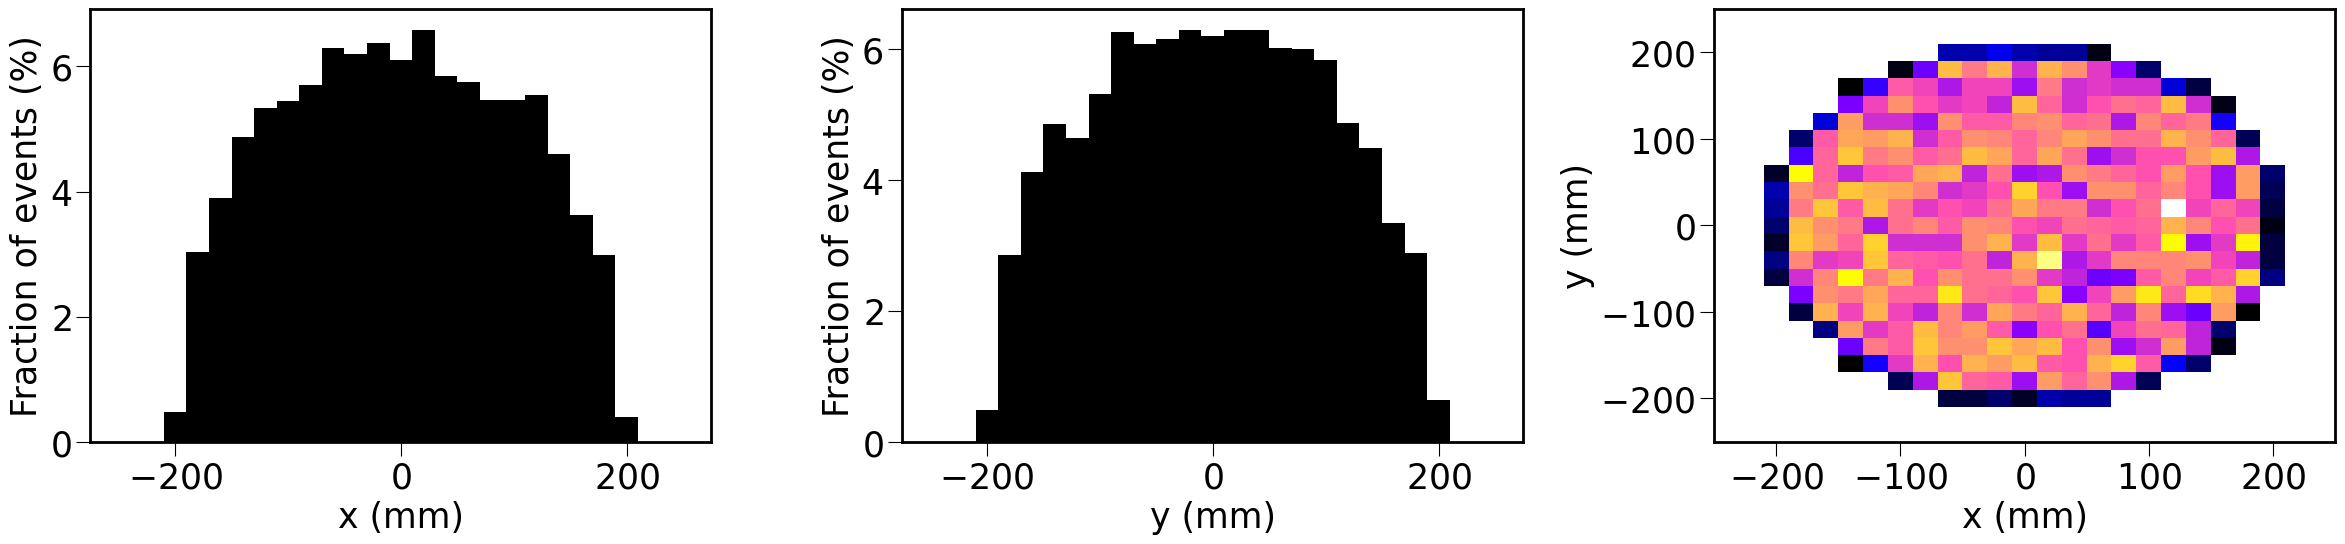

In [5]:
x = df.get_column("xabs")
y = df.get_column("yabs")

bins_xy = np.linspace(-250, 250, 26)

plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1); normhist(x, bins_xy); plt.xlabel("x (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 2); normhist(y, bins_xy); plt.xlabel("y (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 3); plt.hist2d(x, y, (bins_xy,)*2, cmin=1); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

plt.tight_layout()

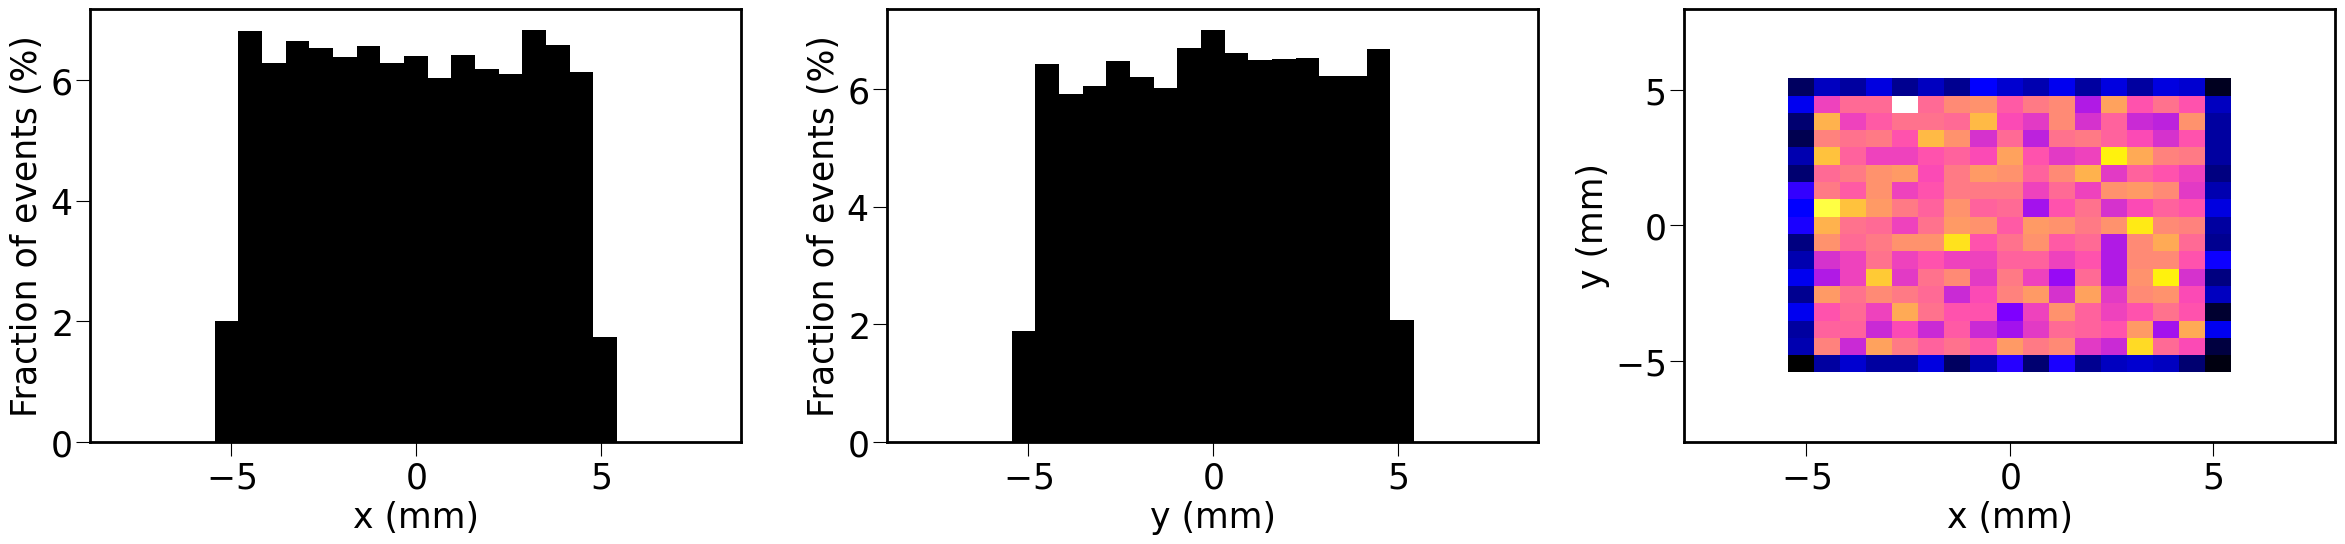

In [6]:
x = df.get_column("x")
y = df.get_column("y")

bins_xy = np.linspace(-8, 8, 26)

plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1); normhist(x, bins_xy); plt.xlabel("x (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 2); normhist(y, bins_xy); plt.xlabel("y (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(1, 3, 3); plt.hist2d(x, y, (bins_xy,)*2, cmin=1); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

plt.tight_layout()

16


Text(0, 0.5, 'y (mm)')

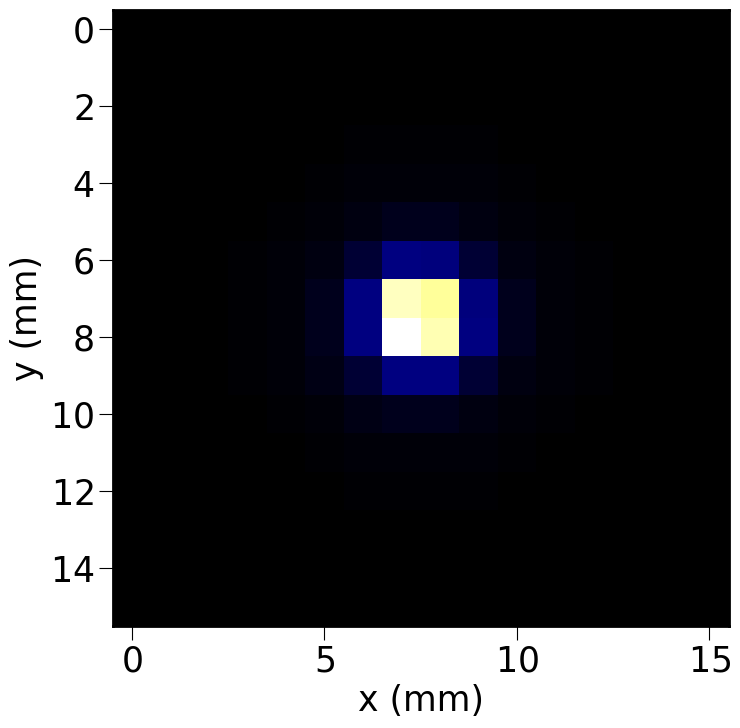

In [7]:
n   = int(response.width**0.5)
print(n)
img = response.sum().to_numpy().reshape(n, n).T
plt.imshow(img); plt.xlabel("x (mm)"); plt.ylabel("y (mm)")

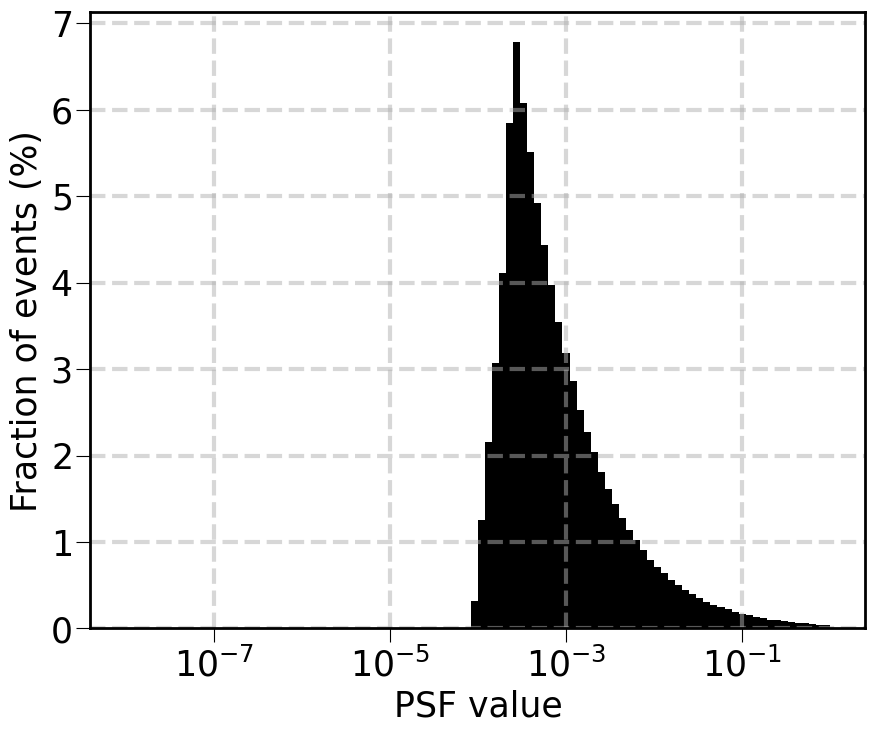

In [8]:
data = np.concatenate([s.to_numpy() for s in response.get_columns()])
normhist(data, np.logspace(-8, 0, 101))
plt.xscale("log")
plt.xlabel("PSF value")
plt.ylabel("Fraction of events (%)")
plt.grid()

# Net

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fnal

from torch.utils.data import Dataset
from torch.utils.data import Subset
from torch.utils.data import DataLoader

## Data loading

In [5]:
f_train = 80
f_valid = 10
assert f_train + f_valid < 100

In [6]:
class DS(Dataset):
    def __init__(self, path : Path, max_files=None):
        self.filenames          = sorted(path.glob("*.parquet"))
        if max_files is not None:
            self.filenames      = self.filenames[:max_files]
        self._n_per_file        = None
        self.pos                = None
        self.response           = None
        self.current_file_index = None

    def load_file(self, file_index):
        self.current_file_index = file_index
        df = pl.read_parquet(self.filenames[file_index])
        self.pos      = df.select(list("xy"))
        self.response = df.select("^sipm.*$")

    @property
    def n_per_file(self):
        if self._n_per_file is None:
            self.load_file(0)
            self._n_per_file = len(self.pos)

        return self._n_per_file

    def indices(self, f_train, f_valid):
        n_train = int(f_train / 100 * len(self))
        n_valid = int(f_valid / 100 * len(self))
        n_test  = len(self) - n_train - n_valid

        idx_train = np.arange(n_train)
        idx_valid = np.arange(n_valid) + n_train
        idx_test  = np.arange(n_test ) + n_train + n_valid
        return idx_train, idx_valid, idx_test

    def __len__(self):
        return self.n_per_file * len(self.filenames)

    def __getitem__(self, i):
        ifile = i // self.n_per_file
        ievt  = i  % self.n_per_file
        if ifile != self.current_file_index:
            self.load_file(ifile)

        pos      = np.array(list(self.pos     .row(ievt)))
        response = np.array(list(self.response.row(ievt)))
        return (pos, response)

In [30]:
ds = DS(folder, 100)

idx_train, idx_valid, idx_test = ds.indices(f_train, f_valid)

ds_train = Subset(ds, idx_train); print(f"Training   data: {len(ds_train):>6d}")
ds_valid = Subset(ds, idx_valid); print(f"Validation data: {len(ds_valid):>6d}")
ds_test  = Subset(ds, idx_test ); print(f"Testing    data: {len(ds_test) :>6d}")

loader_train = DataLoader(ds_train, batch_size=min(1000, ds.n_per_file), shuffle=False)
loader_valid = DataLoader(ds_valid, batch_size=min(1000, ds.n_per_file), shuffle=False)
loader_test  = DataLoader(ds_test , batch_size=min(1000, ds.n_per_file), shuffle=False)

Training   data: 800000
Validation data: 100000
Testing    data: 100000


## Definition

## Training

In [31]:
class NN_linear_v0(nn.Module):
    def __init__(self, nsipms, drop=False):
        super().__init__()
        self.layer1 = nn.Linear(nsipms, 64, dtype=torch.float64)
        self.layer2 = nn.Linear(64    ,  2, dtype=torch.float64)
        self.drop   = nn.Dropout(p=0.05) if drop else None


    def forward(self, x):
        x = torch.relu(self.layer1(x))
        if self.drop is not None:
            x = self.drop(x)
        x =            self.layer2(x)
        return x
    
class NN_linear_v1(nn.Module):
    def __init__(self, nsipms):
        super().__init__()
        nreco    = 2
        self.layer1 = nn.Linear(nsipms, 512, dtype=torch.float64)
        self.layer2 = nn.Linear(   512,  64, dtype=torch.float64)
        self.layer3 = nn.Linear(    64,   2, dtype=torch.float64)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x =            self.layer3(x)
        return x
    
class NN_conv_v0(nn.Module):
    def __init__(self, nsipms):
        super().__init__()
        nreco    = 2
        size     = 2**6
        self.layer1 = nn.Conv2d     (     1, size*1, 4, padding=1, dtype=torch.float64)
        self.norm1  = nn.BatchNorm2d(size*1,                       dtype=torch.float64)
        self.layer2 = nn.Conv2d     (size*1, size*2, 3, padding=1, dtype=torch.float64)
        self.norm2  = nn.BatchNorm2d(size*2,                       dtype=torch.float64)
        self.layer3 = nn.Conv2d     (size*2, size*4, 2, padding=1, dtype=torch.float64)
        self.norm3  = nn.BatchNorm2d(size*4,                       dtype=torch.float64)
        self.layer4 = nn.Linear     (size*4,  nreco,               dtype=torch.float64)

        self.pool   = nn.MaxPool2d(2, 4)
        self.drop   = nn.Dropout(p=0.1)
        
    def print(self, i, *x):
        global netdebug
        if netdebug:
            print(i, *x)

    def forward(self, x):
        x = x.reshape(len(x), 1, nsipms_side, nsipms_side)
        self.print(0, x.shape)
        x = self.pool(self.norm1(fnal.leaky_relu(self.layer1(x)))); self.print(1, x.shape)
        x = self.pool(self.norm2(fnal.leaky_relu(self.layer2(x)))); self.print(2, x.shape)
        x = self.pool(self.norm3(fnal.leaky_relu(self.layer3(x)))); self.print(3, x.shape)
        x = self.layer4(x.flatten(start_dim=1))
        return x
    
    
class NN_conv_v1(nn.Module):
    def __init__(self, nsipms):
        super().__init__()
        nreco    = 2
        size     = 2**6
        self.layer1 = nn.Conv2d     (     1, size*1, 4, padding=2, dtype=torch.float64)
        self.norm1  = nn.BatchNorm2d(size*1,                       dtype=torch.float64)
        self.layer2 = nn.Conv2d     (size*1, size*2, 4, padding=2, dtype=torch.float64)
        self.norm2  = nn.BatchNorm2d(size*2,                       dtype=torch.float64)
        self.layer3 = nn.Linear     (size*2,  nreco,               dtype=torch.float64)

        self.pool   = nn.MaxPool2d(2, 4)
        
    def print(self, i, *x):
        global netdebug
        if netdebug:
            print(i, *x)

    def forward(self, x):
        x = x.reshape(len(x), 1, nsipms_side, nsipms_side)
        self.print(0, x.shape)
        x = self.pool(self.norm1(fnal.leaky_relu(self.layer1(x)))); self.print(1, x.shape)
        x = self.pool(self.norm2(fnal.leaky_relu(self.layer2(x)))); self.print(2, x.shape)
        x = x.flatten(start_dim=1)
        x =                                      self.layer3(x)
        return x
    
class NN_linear_v2(nn.Module):
    def __init__(self, nsipms):
        super().__init__()
        self.layer1 = nn.Linear(nsipms, 128, dtype=torch.float64)
        self.layer2 = nn.Linear(   128,  64, dtype=torch.float64)
        self.layer3 = nn.Linear(    64,   2, dtype=torch.float64)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x =            self.layer3(x)
        return x
    
class NN_conv_v2(nn.Module):
    def __init__(self, nsipms):
        super().__init__()
        self.layer1 = nn.Conv2d(     1,  16, kernel_size=3, stride=1, padding=1, dtype=torch.float64)
        self.layer2 = nn.Conv2d(    16,  32, kernel_size=3, stride=1, padding=1, dtype=torch.float64)
        self.layer3 = nn.Conv2d(    32,  64, kernel_size=3, stride=1, padding=1, dtype=torch.float64)
        self.layer4 = nn.Linear(2*2*64, 128,                                     dtype=torch.float64)
        self.layer5 = nn.Linear(   128,  64,                                     dtype=torch.float64)
        self.layer6 = nn.Linear(    64,   2,                                     dtype=torch.float64)
        self.pool   = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
    def forward(self, x):
        x = x.reshape(len(x), 1, nsipms_side, nsipms_side)
        x = self.pool(torch.relu(self.layer1(x)))
        x = self.pool(torch.relu(self.layer2(x)))
        x = self.pool(torch.relu(self.layer3(x)))
        x = x.view(-1, 2*2*64)
        x = torch.relu(self.layer4(x))
        x = torch.relu(self.layer5(x))
        x =            self.layer6(x)
        return x

In [32]:
netdebug=False

seed = 15945278987002563668
nfiles = 10
lr = 1e-4
nepochs = 20

seed = 16896108185643863306 nfiles = 100 lr = 1e-5 nepochs = 30

seed = 2989494183513620518 nfiles = 10 lr = 1e-4 nepochs = 50

In [33]:
#torch.manual_seed(1234567890)
print("seed =", torch.seed())
nsipms_side = 16
nsipms      = nsipms_side**2
lr          = 1e-5
nepochs     = 20
NN          = NN_linear_v1
model       = NN(nsipms)
lossf       = nn.MSELoss()
optimizer   = optim.Adam(model.parameters(), lr=lr)
losses      = defaultdict(list)

for epoch in range(1, 1+nepochs):
    t0 = time()
    model.train() # inform the model that we are training
    optimizer.zero_grad()
    for i, (pos, response) in enumerate(loader_train, start=1):
        prediction = model(response)
        loss       = lossf(prediction, pos)
        loss     .backward()
        optimizer.step()

        losses[epoch].append(loss.data.item())
        
    validation_loss = []
    with torch.no_grad():
        model.eval() # tell the model that we are evaluating
        for i, (pos, response) in enumerate(loader_valid, start=1):
            prediction = model(response)
            loss       = lossf(prediction, pos)
            validation_loss.append(loss.data.item())
            
    dt = time() - t0
    print(f"Epoch [{epoch}/{nepochs}], Loss: {losses[epoch][-1]:.4f}, Val loss: {np.mean(validation_loss):.1f}, LR: {lr : .4f} DT : {dt:.1f}")
    #lr = max(0.75 * lr, 1e-4)

seed = 1802610105865725067
Epoch [1/20], Loss: 7.8454, Val loss: 7.8, LR:  0.0000 DT : 75.3
Epoch [2/20], Loss: 6.9671, Val loss: 7.0, LR:  0.0000 DT : 82.2
Epoch [3/20], Loss: 5.7968, Val loss: 5.8, LR:  0.0000 DT : 84.3
Epoch [4/20], Loss: 4.4597, Val loss: 4.5, LR:  0.0000 DT : 74.8
Epoch [5/20], Loss: 3.1008, Val loss: 3.1, LR:  0.0000 DT : 74.2
Epoch [6/20], Loss: 1.9258, Val loss: 1.9, LR:  0.0000 DT : 113.5
Epoch [7/20], Loss: 1.0433, Val loss: 1.1, LR:  0.0000 DT : 112.3
Epoch [8/20], Loss: 0.5602, Val loss: 0.6, LR:  0.0000 DT : 140.8
Epoch [9/20], Loss: 0.3856, Val loss: 0.4, LR:  0.0000 DT : 86.1
Epoch [10/20], Loss: 0.3480, Val loss: 0.4, LR:  0.0000 DT : 83.2
Epoch [11/20], Loss: 0.3301, Val loss: 0.4, LR:  0.0000 DT : 83.3
Epoch [12/20], Loss: 0.3167, Val loss: 0.3, LR:  0.0000 DT : 82.4
Epoch [13/20], Loss: 0.3092, Val loss: 0.3, LR:  0.0000 DT : 84.5
Epoch [14/20], Loss: 0.3057, Val loss: 0.3, LR:  0.0000 DT : 94.5
Epoch [15/20], Loss: 0.3229, Val loss: 0.3, LR:  0.0000

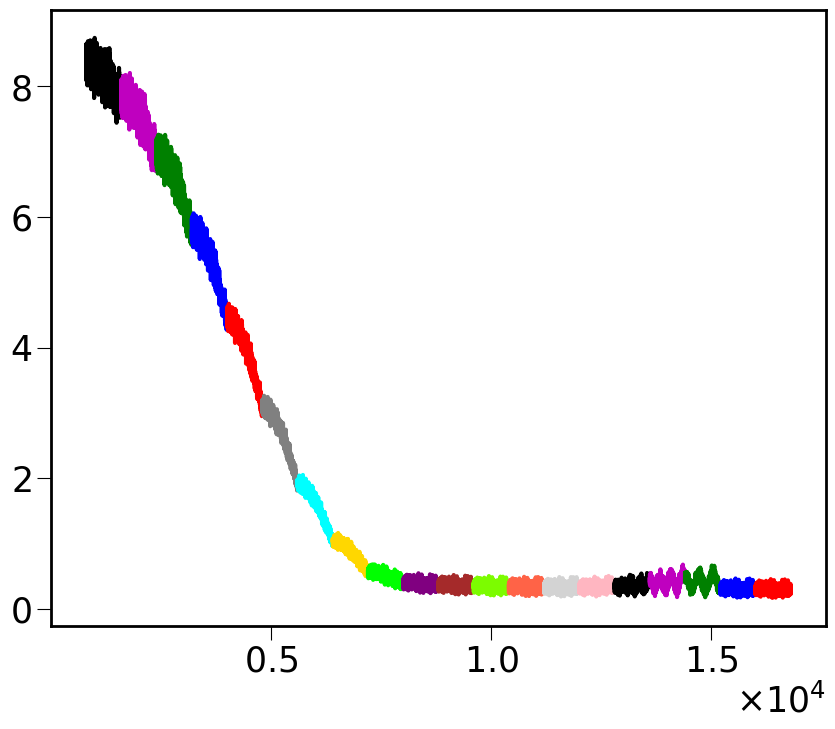

In [34]:
for ie, ep in sorted(losses.items()):
    plt.plot(np.arange(len(ep))+ie*len(ep), ep)

## Testing

In [35]:
dxs, dys, dps, ps = [[] for i in range(4)]
with torch.no_grad():
    model.eval()
    for pos, response in loader_test:
        predicted = model(response)
        dx, dy    = (predicted - pos).numpy().T
        dxs.extend(dx)
        dys.extend(dy)
        dps.extend((dx**2 + dy**2)**0.5)
        ps.extend((pos**2).sum(axis=1)**0.5)

In [36]:
true_pos, response = next(iter(loader_test))
model.eval()
predicted  = model(response[:1])
for axis, t, p in zip("xy", true_pos[0], predicted[0]):
    print(axis, t, p)

x tensor(2.0792, dtype=torch.float64) tensor(2.3632, dtype=torch.float64, grad_fn=<UnbindBackward0>)
y tensor(3.3455, dtype=torch.float64) tensor(3.3250, dtype=torch.float64, grad_fn=<UnbindBackward0>)


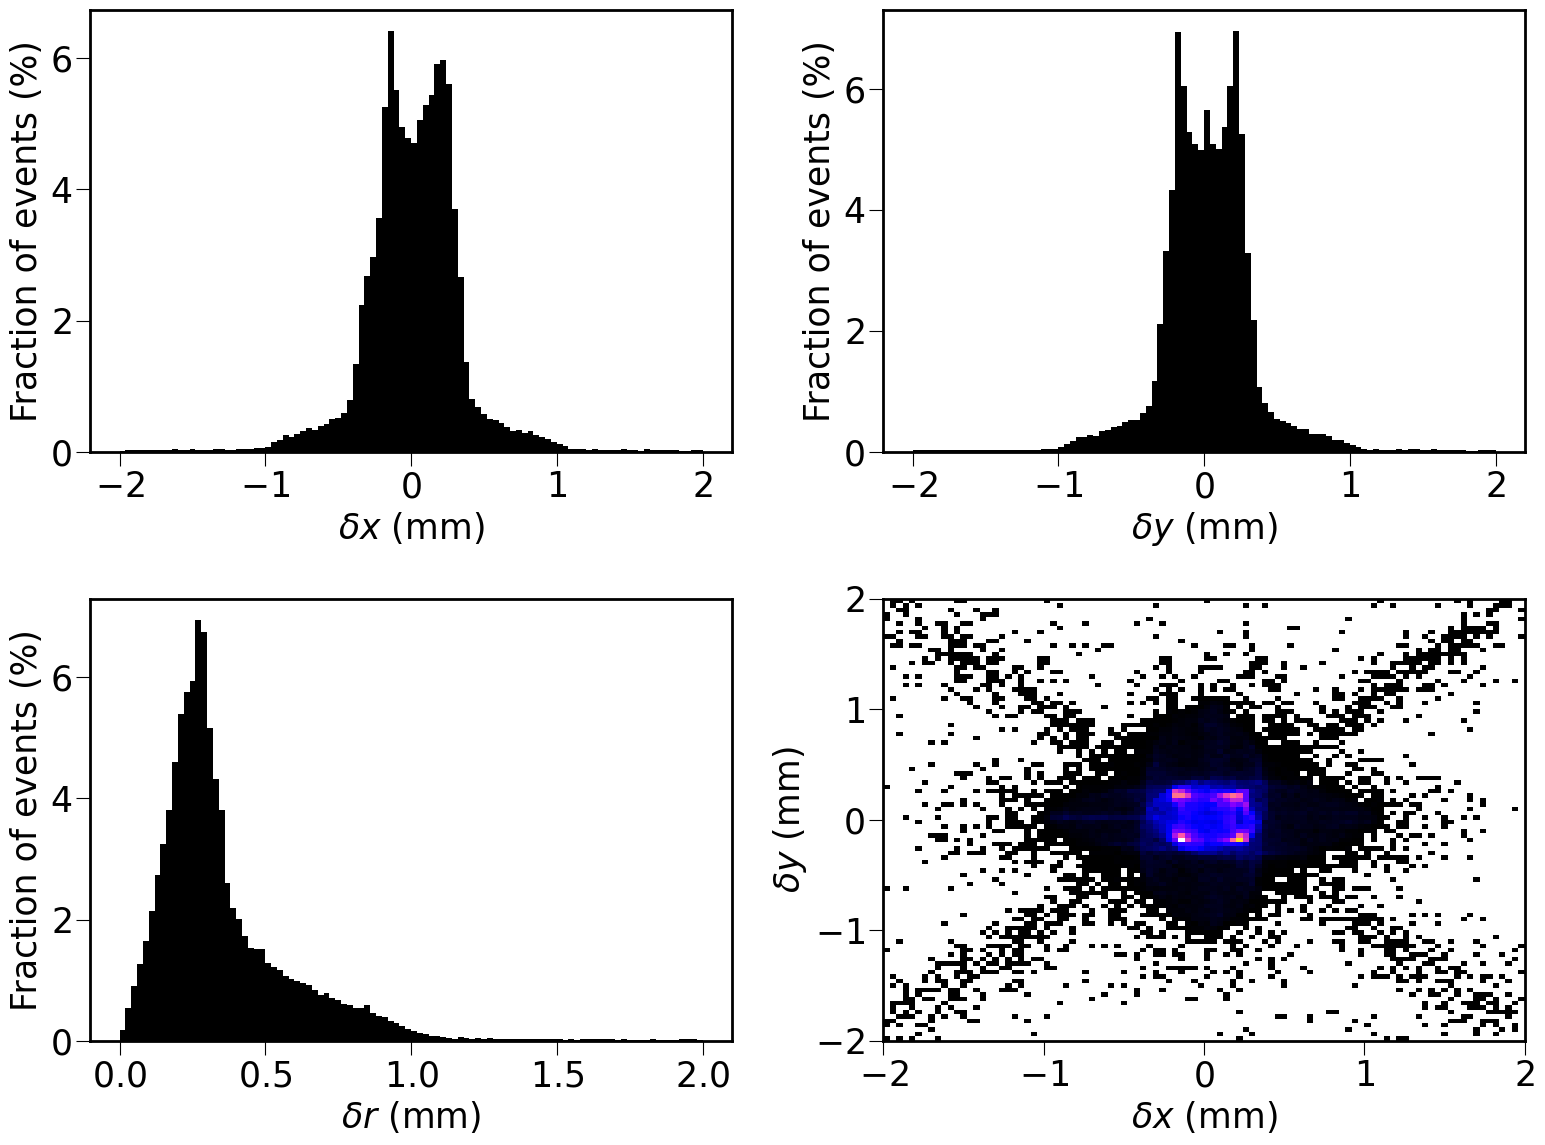

In [37]:
bins_dxy = np.linspace(-2, 2, 101)
bins_dr  = np.linspace( 0, 2, 101)

plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1); normhist(dxs, bins_dxy); plt.xlabel("$\delta x$ (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 2); normhist(dys, bins_dxy); plt.xlabel("$\delta y$ (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 3); normhist(dps, bins_dr ); plt.xlabel("$\delta r$ (mm)"); plt.ylabel("Fraction of events (%)")
plt.subplot(2, 2, 4); plt.hist2d(dxs, dys, (bins_dxy,)*2, cmin=1); plt.xlabel("$\delta x$ (mm)"); plt.ylabel("$\delta y$ (mm)")

plt.tight_layout()

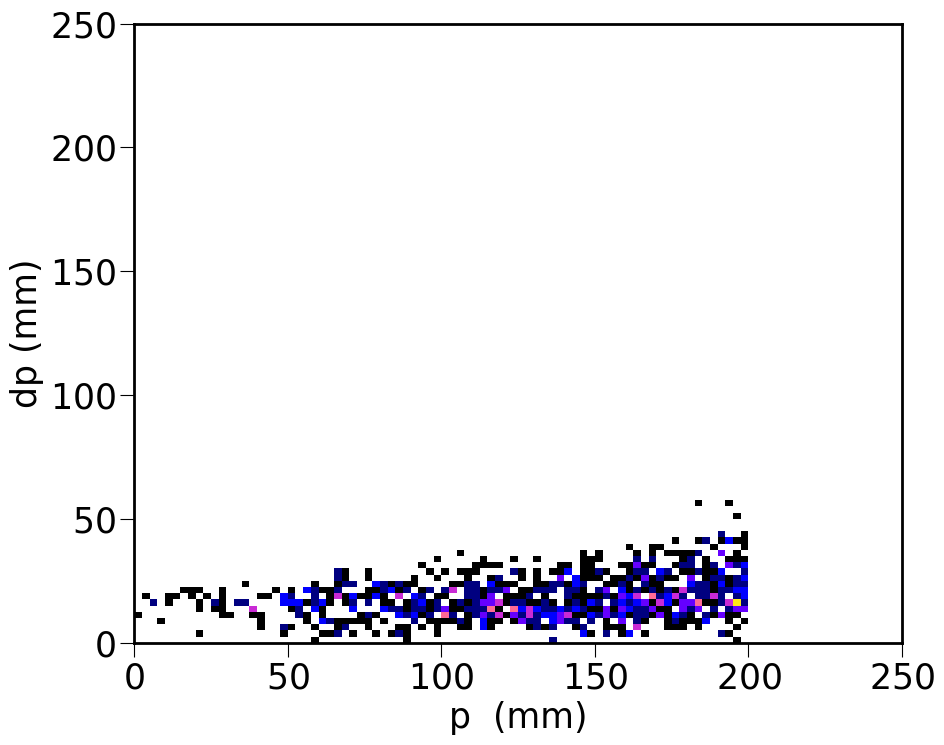

In [26]:
bins_r = np.linspace(0, bins_xy.max(), 101)
plt.hist2d(ps, dps, (bins_r, bins_dr), cmin=1)
plt.xlabel("p  (mm)")
plt.ylabel("dp (mm)")

plt.tight_layout()